\newpage

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
import warnings
from sklearn.exceptions import DataConversionWarning

# Suppress DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

C:\Users\melin\AppData\Local\Temp\ipykernel_4164\2646944835.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Question 1 - Classification Problem Identification
This dataset is 2 months worth of data with 25 features (such as blood pressure, albumin, pus cell, etc.). Using these features, I will attempt to classify whether each patient has chronic kidney disease. 

### Question 2 - Variable Transformation
Note that the same dataset posted on https://archive.ics.uci.edu/dataset/336/chronic+kidney+disease is also available on Kaggle, https://www.kaggle.com/datasets/mansoordaku/ckdisease/data. The .csv file in the following code has been downloaded from that Kaggle page. To understand how the variables need to be transformed, we can perform some initial exploration of the data.

In [2]:
# Importing data
df = pd.read_csv('kidney_disease.csv')

# Initial exploration of data
print('Initial exploration of data:')
display(df.head())

print('Data dimensions:')
display(df.shape)  # 400 patients, 25 variables

print('Summary of non-null counts and datatypes:')
display(df.info())


Initial exploration of data:


,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd


Data dimensions:


(400, 26)

Summary of non-null counts and datatypes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              400 non-null    int64  
 1   age             391 non-null    float64
 2   bp              388 non-null    float64
 3   sg              353 non-null    float64
 4   al              354 non-null    float64
 5   su              351 non-null    float64
 6   rbc             248 non-null    object 
 7   pc              335 non-null    object 
 8   pcc             396 non-null    object 
 9   ba              396 non-null    object 
 10  bgr             356 non-null    float64
 11  bu              381 non-null    float64
 12  sc              383 non-null    float64
 13  sod             313 non-null    float64
 14  pot             312 non-null    float64
 15  hemo            348 non-null    float64
 16  pcv             330 non-null    object

None

To make the data easier to read, we can rename the column variables to be more descriptive. 

In [3]:
new_col_names = ['id','age','blood_pressure','specific_gravity','albumin','sugar','red_blood_cells','pus_cells',
                 'pus_cell_clumps','bacteria','blood_gluc_random','blood_urea','serum_creatinine','sodium','potassium',
                 'hemoglobin','packed_cell_vol','white_cell_count','red_cell_count','hypertension','diabetes_mel', 
                 'coronary_heart_disease', 'appetite','pedal_enema','anemia','class']

df.rename(columns=dict(zip(df.columns, new_col_names)), inplace=True)

We can look at the unique values of each column to look for any typos or errors

In [4]:
df = df.drop(columns=['id'])
for col in df.columns:
    print(col)
    display(df[col].unique())

age


array([48.,  7., 62., 51., 60., 68., 24., 52., 53., 50., 63., 40., 47.,
       61., 21., 42., 75., 69., nan, 73., 70., 65., 76., 72., 82., 46.,
       45., 35., 54., 11., 59., 67., 15., 55., 44., 26., 64., 56.,  5.,
       74., 38., 58., 71., 34., 17., 12., 43., 41., 57.,  8., 39., 66.,
       81., 14., 27., 83., 30.,  4.,  3.,  6., 32., 80., 49., 90., 78.,
       19.,  2., 33., 36., 37., 23., 25., 20., 29., 28., 22., 79.])

blood_pressure


array([ 80.,  50.,  70.,  90.,  nan, 100.,  60., 110., 140., 180., 120.])

specific_gravity


array([1.02 , 1.01 , 1.005, 1.015,   nan, 1.025])

albumin


array([ 1.,  4.,  2.,  3.,  0., nan,  5.])

sugar


array([ 0.,  3.,  4.,  1., nan,  2.,  5.])

red_blood_cells


array([nan, 'normal', 'abnormal'], dtype=object)

pus_cells


array(['normal', 'abnormal', nan], dtype=object)

pus_cell_clumps


array(['notpresent', 'present', nan], dtype=object)

bacteria


array(['notpresent', 'present', nan], dtype=object)

blood_gluc_random


array([121.,  nan, 423., 117., 106.,  74., 100., 410., 138.,  70., 490.,
       380., 208.,  98., 157.,  76.,  99., 114., 263., 173.,  95., 108.,
       156., 264., 123.,  93., 107., 159., 140., 171., 270.,  92., 137.,
       204.,  79., 207., 124., 144.,  91., 162., 246., 253., 141., 182.,
        86., 150., 146., 425., 112., 250., 360., 163., 129., 133., 102.,
       158., 165., 132., 104., 127., 415., 169., 251., 109., 280., 210.,
       219., 295.,  94., 172., 101., 298., 153.,  88., 226., 143., 115.,
        89., 297., 233., 294., 323., 125.,  90., 308., 118., 224., 128.,
       122., 214., 213., 268., 256.,  84., 105., 288., 139.,  78., 273.,
       242., 424., 303., 148., 160., 192., 307., 220., 447., 309.,  22.,
       111., 261., 215., 234., 131., 352.,  80., 239., 110., 130., 184.,
       252., 113., 230., 341., 255., 103., 238., 248., 120., 241., 269.,
       201., 203., 463., 176.,  82., 119.,  97.,  96.,  81., 116., 134.,
        85.,  83.,  87.,  75.])

blood_urea


array([ 36. ,  18. ,  53. ,  56. ,  26. ,  25. ,  54. ,  31. ,  60. ,
       107. ,  55. ,  72. ,  86. ,  90. , 162. ,  46. ,  87. ,  27. ,
       148. , 180. , 163. ,   nan,  50. ,  75. ,  45. ,  28. , 155. ,
        33. ,  39. , 153. ,  29. ,  65. , 103. ,  70. ,  80. ,  20. ,
       202. ,  77. ,  89. ,  24. ,  17. ,  32. , 114. ,  66. ,  38. ,
       164. , 142. ,  96. , 391. ,  15. , 111. ,  73. ,  19. ,  92. ,
        35. ,  16. , 139. ,  48. ,  85. ,  98. , 186. ,  37. ,  47. ,
        52. ,  82. ,  51. , 106. ,  22. , 217. ,  88. , 118. ,  50.1,
        71. ,  34. ,  40. ,  21. , 219. ,  30. , 125. , 166. ,  49. ,
       208. , 176. ,  68. , 145. , 165. , 322. ,  23. , 235. , 132. ,
        76. ,  42. ,  44. ,  41. , 113. ,   1.5, 146. ,  58. , 133. ,
       137. ,  67. , 115. , 223. ,  98.6, 158. ,  94. ,  74. , 150. ,
        61. ,  57. ,  95. , 191. ,  93. , 241. ,  64. ,  79. , 215. ,
       309. ,  10. ])

serum_creatinine


array([ 1.2 ,  0.8 ,  1.8 ,  3.8 ,  1.4 ,  1.1 , 24.  ,  1.9 ,  7.2 ,
        4.  ,  2.7 ,  2.1 ,  4.6 ,  4.1 ,  9.6 ,  2.2 ,  5.2 ,  1.3 ,
        1.6 ,  3.9 , 76.  ,  7.7 ,   nan,  2.4 ,  7.3 ,  1.5 ,  2.5 ,
        2.  ,  3.4 ,  0.7 ,  1.  , 10.8 ,  6.3 ,  5.9 ,  0.9 ,  3.  ,
        3.25,  9.7 ,  6.4 ,  3.2 , 32.  ,  0.6 ,  6.1 ,  3.3 ,  6.7 ,
        8.5 ,  2.8 , 15.  ,  2.9 ,  1.7 ,  3.6 ,  5.6 ,  6.5 ,  4.4 ,
       10.2 , 11.5 ,  0.5 , 12.2 ,  5.3 ,  9.2 , 13.8 , 16.9 ,  6.  ,
        7.1 , 18.  ,  2.3 , 13.  , 48.1 , 14.2 , 16.4 ,  2.6 ,  7.5 ,
        4.3 , 18.1 , 11.8 ,  9.3 ,  6.8 , 13.5 , 12.8 , 11.9 , 12.  ,
       13.4 , 15.2 , 13.3 ,  0.4 ])

sodium


array([  nan, 111. , 142. , 104. , 114. , 131. , 138. , 135. , 130. ,
       141. , 139. ,   4.5, 136. , 129. , 140. , 132. , 133. , 134. ,
       125. , 163. , 137. , 128. , 143. , 127. , 146. , 126. , 122. ,
       147. , 124. , 115. , 145. , 113. , 120. , 150. , 144. ])

potassium


array([ nan,  2.5,  3.2,  4. ,  3.7,  4.2,  5.8,  3.4,  6.4,  4.9,  4.1,
        4.3,  5.2,  3.8,  4.6,  3.9,  4.7,  5.9,  4.8,  4.4,  6.6, 39. ,
        5.5,  5. ,  3.5,  3.6,  7.6,  2.9,  4.5,  5.7,  5.4,  5.3, 47. ,
        6.3,  5.1,  5.6,  3. ,  2.8,  2.7,  6.5,  3.3])

hemoglobin


array([15.4, 11.3,  9.6, 11.2, 11.6, 12.2, 12.4, 10.8,  9.5,  9.4,  9.7,
        9.8,  5.6,  7.6, 12.6, 12.1, 12.7, 10.3,  7.7, 10.9,  nan, 11.1,
        9.9, 12.5, 12.9, 10.1, 12. , 13. ,  7.9,  9.3, 15. , 10. ,  8.6,
       13.6, 10.2, 10.5,  6.6, 11. ,  7.5, 15.6, 15.2,  4.8,  9.1,  8.1,
       11.9, 13.5,  8.3,  7.1, 16.1, 10.4,  9.2,  6.2, 13.9, 14.1,  6. ,
       11.8, 11.7, 11.4, 14. ,  8.2, 13.2,  6.1,  8. , 12.3,  8.4, 14.3,
        9. ,  8.7, 10.6, 13.1, 10.7,  5.5,  5.8,  6.8,  8.8,  8.5, 13.8,
       11.5,  7.3, 13.7, 12.8, 13.4,  6.3,  3.1, 17. , 15.9, 14.5, 15.5,
       16.2, 14.4, 14.2, 16.3, 14.8, 16.5, 15.7, 13.3, 14.6, 16.4, 16.9,
       16. , 14.7, 16.6, 14.9, 16.7, 16.8, 15.8, 15.1, 17.1, 17.2, 15.3,
       17.3, 17.4, 17.7, 17.8, 17.5, 17.6])

packed_cell_vol


array(['44', '38', '31', '32', '35', '39', '36', '33', '29', '28', nan,
       '16', '24', '37', '30', '34', '40', '45', '27', '48', '\t?', '52',
       '14', '22', '18', '42', '17', '46', '23', '19', '25', '41', '26',
       '15', '21', '43', '20', '\t43', '47', '9', '49', '50', '53', '51',
       '54'], dtype=object)

white_cell_count


array(['7800', '6000', '7500', '6700', '7300', nan, '6900', '9600',
       '12100', '4500', '12200', '11000', '3800', '11400', '5300', '9200',
       '6200', '8300', '8400', '10300', '9800', '9100', '7900', '6400',
       '8600', '18900', '21600', '4300', '8500', '11300', '7200', '7700',
       '14600', '6300', '\t6200', '7100', '11800', '9400', '5500', '5800',
       '13200', '12500', '5600', '7000', '11900', '10400', '10700',
       '12700', '6800', '6500', '13600', '10200', '9000', '14900', '8200',
       '15200', '5000', '16300', '12400', '\t8400', '10500', '4200',
       '4700', '10900', '8100', '9500', '2200', '12800', '11200', '19100',
       '\t?', '12300', '16700', '2600', '26400', '8800', '7400', '4900',
       '8000', '12000', '15700', '4100', '5700', '11500', '5400', '10800',
       '9900', '5200', '5900', '9300', '9700', '5100', '6600'],
      dtype=object)

red_cell_count


array(['5.2', nan, '3.9', '4.6', '4.4', '5', '4.0', '3.7', '3.8', '3.4',
       '2.6', '2.8', '4.3', '3.2', '3.6', '4', '4.1', '4.9', '2.5', '4.2',
       '4.5', '3.1', '4.7', '3.5', '6.0', '5.0', '2.1', '5.6', '2.3',
       '2.9', '2.7', '8.0', '3.3', '3.0', '3', '2.4', '4.8', '\t?', '5.4',
       '6.1', '6.2', '6.3', '5.1', '5.8', '5.5', '5.3', '6.4', '5.7',
       '5.9', '6.5'], dtype=object)

hypertension


array(['yes', 'no', nan], dtype=object)

diabetes_mel


array(['yes', 'no', ' yes', '\tno', '\tyes', nan], dtype=object)

coronary_heart_disease


array(['no', 'yes', '\tno', nan], dtype=object)

appetite


array(['good', 'poor', nan], dtype=object)

pedal_enema


array(['no', 'yes', nan], dtype=object)

anemia


array(['no', 'yes', nan], dtype=object)

class


array(['ckd', 'ckd\t', 'notckd'], dtype=object)

Based on the description of variables in the documentation, we expect that the values for packed cell volume (pcv), white blood cell count (wc), and red blood cell (rc) count to be continuous. However, they have been miscast as strings. 

Also, the categorical variables for diabaetes mellitus, coronary heart disease, and class have typos that need to be fixed.

In [5]:
err_cols = ['packed_cell_vol', 'red_cell_count', 'white_cell_count']

for err_col in err_cols:
    df[err_col] = df[err_col].replace('\t?', np.nan)
    df[err_col] = df[err_col].str.replace('\t', '')
    df[err_col] = df[err_col].astype(np.float64)

# Checking that it converted properly, looking for float64 in the columns with problems
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     391 non-null    float64
 1   blood_pressure          388 non-null    float64
 2   specific_gravity        353 non-null    float64
 3   albumin                 354 non-null    float64
 4   sugar                   351 non-null    float64
 5   red_blood_cells         248 non-null    object 
 6   pus_cells               335 non-null    object 
 7   pus_cell_clumps         396 non-null    object 
 8   bacteria                396 non-null    object 
 9   blood_gluc_random       356 non-null    float64
 10  blood_urea              381 non-null    float64
 11  serum_creatinine        383 non-null    float64
 12  sodium                  313 non-null    float64
 13  potassium               312 non-null    float64
 14  hemoglobin              348 non-null    fl

In [6]:
err_cols = ['diabetes_mel', 'coronary_heart_disease', 'class']

for err_col in err_cols:
    print(err_col)
    df[err_col] = df[err_col].str.replace('\t', '')
    df[err_col] = df[err_col].str.replace(' ', '')
    display(df[err_col].unique())

diabetes_mel


array(['yes', 'no', nan], dtype=object)

coronary_heart_disease


array(['no', 'yes', nan], dtype=object)

class


array(['ckd', 'notckd'], dtype=object)

Now that typos and miscast variables have been cleaned up, we can continue with the analysis. 

In [7]:
df.describe()

,age,blood_pressure,specific_gravity,albumin,sugar,blood_gluc_random,blood_urea,serum_creatinine,sodium,potassium,hemoglobin,packed_cell_vol,white_cell_count,red_cell_count
count,391.000000,388.000000,353.000000,354.000000,351.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000,329.000000,294.000000,269.000000
mean,51.483376,76.469072,1.017408,1.016949,0.450142,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437,38.884498,8406.122449,4.707435
std,17.169714,13.683637,0.005717,1.352679,1.099191,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587,8.990105,2944.474190,1.025323
min,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000,9.000000,2200.000000,2.100000
25%,42.000000,70.000000,1.010000,0.000000,0.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000,32.000000,6500.000000,3.900000
50%,55.000000,80.000000,1.020000,0.000000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000,40.000000,8000.000000,4.800000
75%,64.500000,80.000000,1.020000,2.000000,0.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000,45.000000,9800.000000,5.400000
max,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000,54.000000,26400.000000,8.000000


Based on the description of the continuous variables, we can see that the scale of the columns are very different. For example, the max value of blood pressure (bp) is 180, while specific gravity's (sg) max vaule is 1.03. So, the variables will need to be scaled so the data is not skewed in the direction of the larger variables. 

To make the data easier to read, we will replace the names with more descriptive names.

### Question 3 - Dataset Overview
Based on the initial exploration shown above and the documentation associated with the dataset, we know the following about the data. 
* There are 400 patients recorded with 25 variables recorded for each. These variables can be seperated into categorical, binary, and continuous variables. The list of variables are: age, blood pressure (bp), specific gravity (sg), albumin (al), sugar (su), red blood cells (rbc), pus cell (pc), pus cell clumps (pcc), bacteria (ba), blood glucose random (bgr), blood urea (bu), serum creatinine (sc), sodium (sod), potassium (pot), hemoglobin (hemo), packed cell volume (pcv), white blood cell count (wc), red blood cell count (rc), hyptertension (htn), coronary artery disease (cad), diabetes mellitus (dm), appetite (appet), pedal edema (pe), anemia (ane).
* Based on the standard deviation
* *****


### Question 4 - Association Between Variables
To do this, we can look at the covariance structure of the numerical variables.

In [8]:
# Take subset of continuous variables only
df_cont_vars = df.copy()
continuous_vars = df_cont_vars.select_dtypes(include=['float64']).columns
df_cont_vars = df_cont_vars[continuous_vars]

# Drop nan values
df_cont_vars.dropna(inplace=True)

# Plot correlation matrix
corr = df_cont_vars.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=2)

,age,blood_pressure,specific_gravity,albumin,sugar,blood_gluc_random,blood_urea,serum_creatinine,sodium,potassium,hemoglobin,packed_cell_vol,white_cell_count,red_cell_count
age,1.00,0.15,-0.30,0.21,0.23,0.28,0.16,0.16,-0.13,0.00,-0.24,-0.25,0.17,-0.24
blood_pressure,0.15,1.00,-0.26,0.28,0.26,0.21,0.26,0.34,-0.20,0.09,-0.30,-0.33,0.08,-0.24
specific_gravity,-0.30,-0.26,1.00,-0.61,-0.39,-0.46,-0.48,-0.51,0.51,-0.05,0.68,0.67,-0.27,0.61
albumin,0.21,0.28,-0.61,1.00,0.42,0.44,0.60,0.63,-0.56,0.19,-0.71,-0.69,0.26,-0.59
sugar,0.23,0.26,-0.39,0.42,1.00,0.79,0.21,0.23,-0.27,0.19,-0.30,-0.32,0.22,-0.29
blood_gluc_random,0.28,0.21,-0.46,0.44,0.79,1.00,0.24,0.22,-0.31,0.06,-0.35,-0.36,0.21,-0.32
blood_urea,0.16,0.26,-0.48,0.60,0.21,0.24,1.00,0.86,-0.48,0.22,-0.67,-0.65,0.09,-0.59
serum_creatinine,0.16,0.34,-0.51,0.63,0.23,0.22,0.86,1.00,-0.49,0.13,-0.66,-0.66,0.08,-0.59
sodium,-0.13,-0.20,0.51,-0.56,-0.27,-0.31,-0.48,-0.49,1.00,-0.05,0.54,0.54,-0.18,0.44
potassium,0.00,0.09,-0.05,0.19,0.19,0.06,0.22,0.13,-0.05,1.00,-0.16,-0.19,-0.10,-0.18


This plot, shows the highest positive correlation is between sugar (su) and blood glucose random (bgr). This intuitively makes sense since those are biologically correlated processes. The greatest negative correlation is between hemoglobin and albumin, which is also known to be negatively correlated.
* Due to the high correlation shown between sugar and blood glucose random, there may be some redundancy between the two variables. Keeping both variables may unnecessarily increase dimensionality (although they're not too highly correlated so it's likely best to leave both variables in)
* Any highly correlated values could undergo dimensionality reduction via techniques like PCA as they will be redundant when calculating the principal components.
* Having variables that are both highly positively and negatively correlated means that classification is likely possible since there are large differences between variables in the dataset.

### Question 5 - Missing Value Analysis 
To handle missing values, we can either drop all rows with missing values (nans) or somehow interpolate the values with missing values. First we can check to see how many rows would be dropped if all nans were dropped.

In [9]:
print(400-df.dropna().shape[0], 'rows would be dropped due to nan values')

242 rows would be dropped due to nan values


Since so many rows would be dropped due to nan values, it is better to impute the values. This can be done with a univariate, multivariate, or nearest neighbours imputation (via scikit-learn, https://scikit-learn.org/stable/modules/impute.html). Since we are most familiar with KNN which was studied during this course, we will use that to impute the data. Note that the data needs to be scaled since KNN calculates the Eucledian distance.

In [10]:
# Take subset of continuous variables only
df_cont_vars = df.copy()
continuous_vars = df_cont_vars.select_dtypes(include=['float64']).columns
df_cont_vars = df_cont_vars[continuous_vars]

# Scaling data
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_cont_vars), columns=df_cont_vars.columns)

# Imputing data
impute = KNNImputer(n_neighbors=8)  # n=8 picked because this improved imputing distribution 
df_imputed = pd.DataFrame(impute.fit_transform(df_scaled), columns=df_scaled.columns)
df_imputed.isnull().sum()

df_final = df.copy()
df_final.update(df_imputed)
df_final.isnull().sum()

age                         0
blood_pressure              0
specific_gravity            0
albumin                     0
sugar                       0
red_blood_cells           152
pus_cells                  65
pus_cell_clumps             4
bacteria                    4
blood_gluc_random           0
blood_urea                  0
serum_creatinine            0
sodium                      0
potassium                   0
hemoglobin                  0
packed_cell_vol             0
white_cell_count            0
red_cell_count              0
hypertension                2
diabetes_mel                2
coronary_heart_disease      2
appetite                    1
pedal_enema                 1
anemia                      1
class                       0
dtype: int64

So, there are no null values in the continuous value columns since the data was imputed, and this can be used instead of the original dataset.

### Question 6 - Outlier Analysis
We can look at the outliers with a boxplot of the continuous variables. 

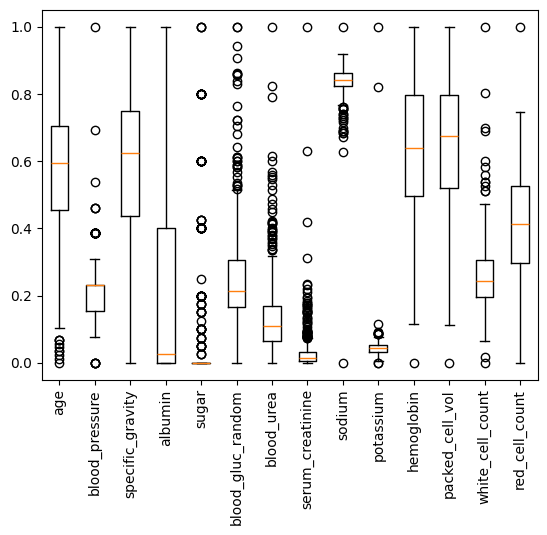

In [11]:
plt.boxplot(df_imputed)
plt.xticks(range(1, len(df_imputed.columns) + 1), df_imputed.columns, rotation=90)
plt.show()

For now we will ignore the outliers in case they are important to the overall analysis. There may be some important data captured in the outliers, and removing all outliers indiscriminantly may impact the clustering accuracy.

One option in the future is to remove all data points that lie outside a certain quartile range.

### Question 7 - Sub Group Analysis

To consider the sub groups, we can look at the distribution of patients values in different columns. We expect a normal distribution, but if there are multiple peaks that may indicate the existence of subgroups

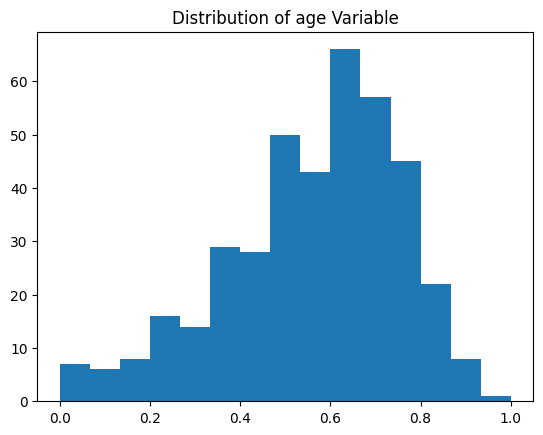

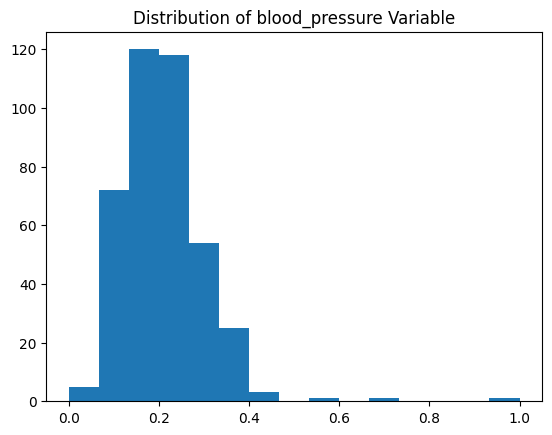

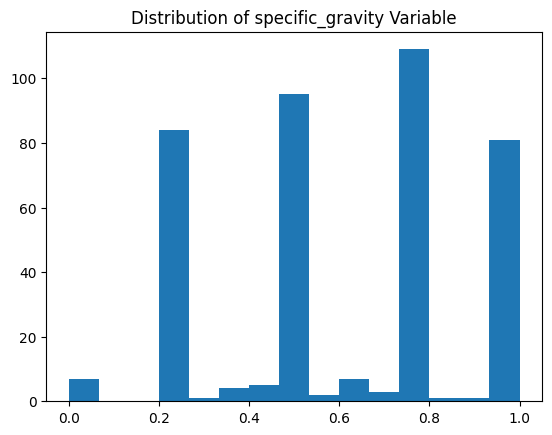

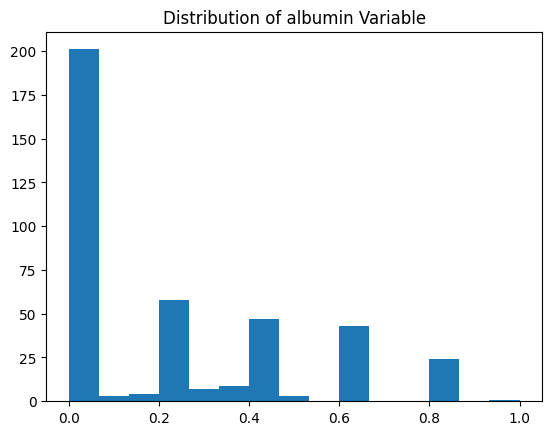

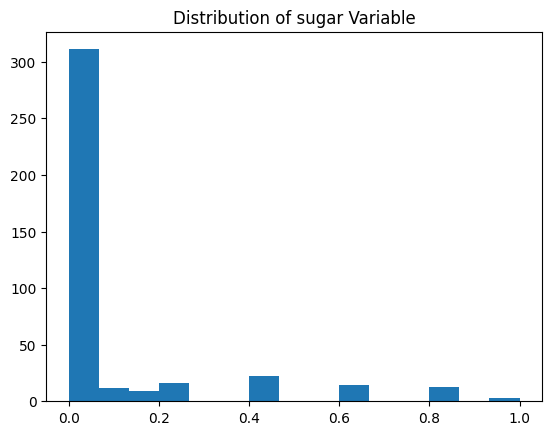

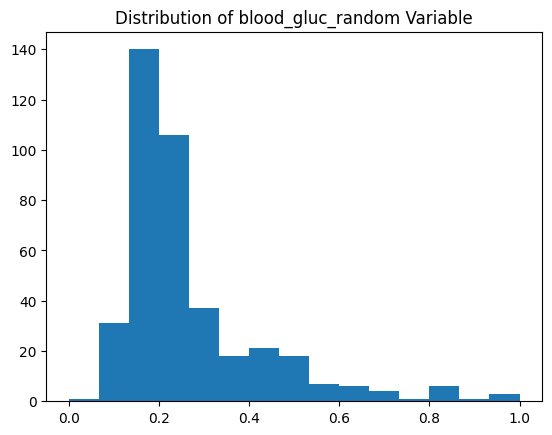

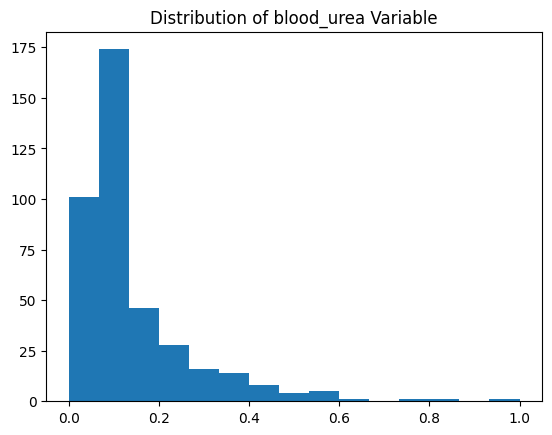

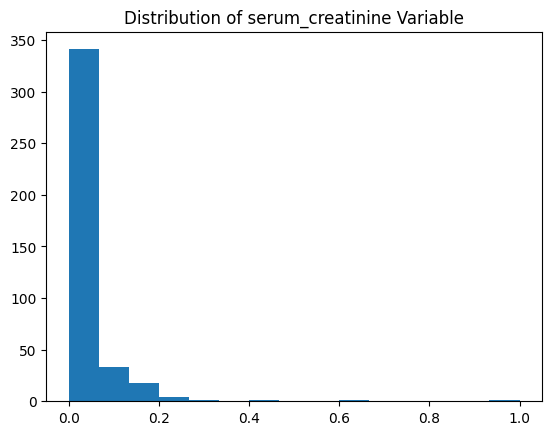

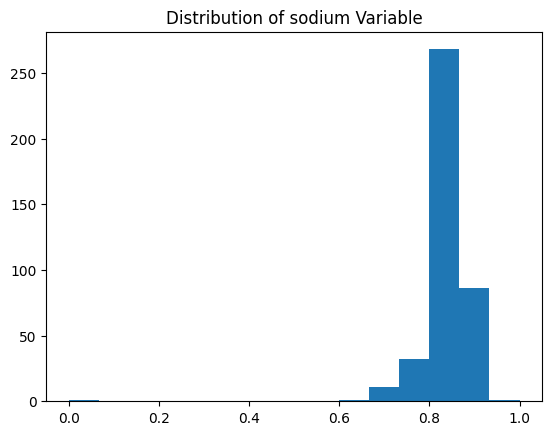

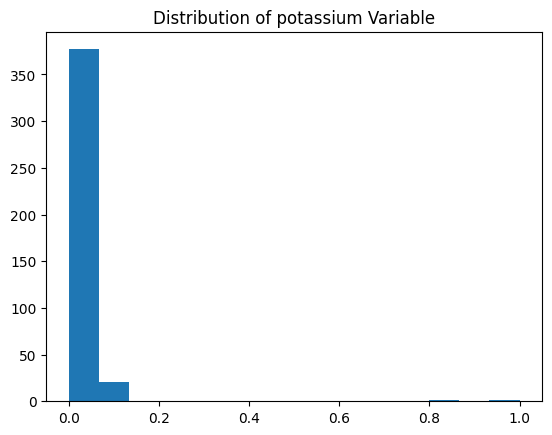

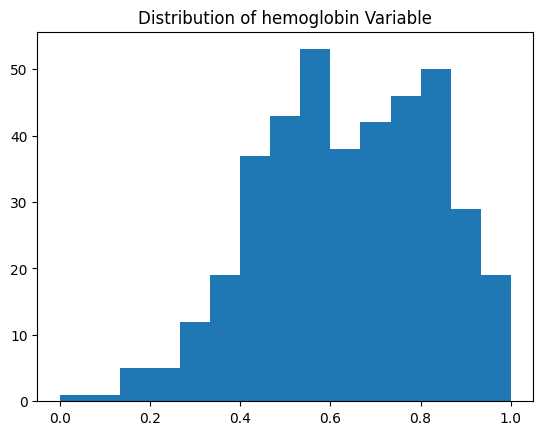

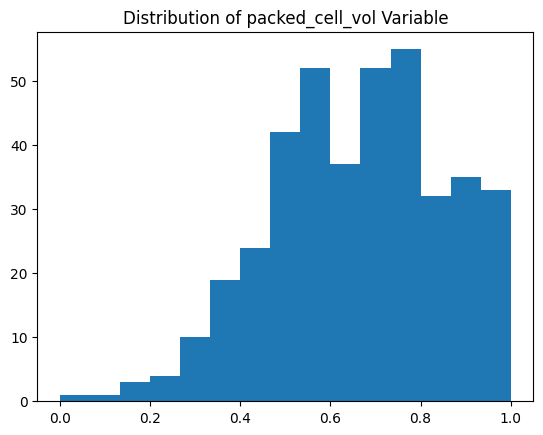

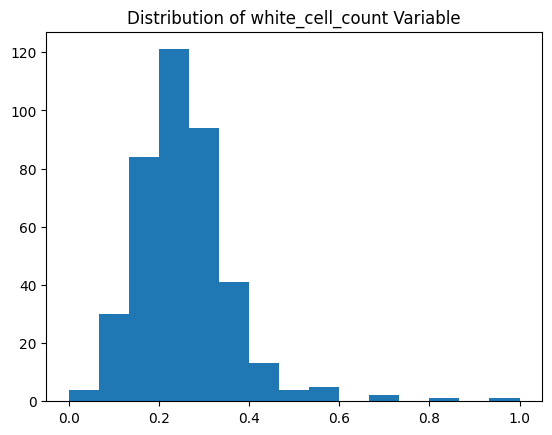

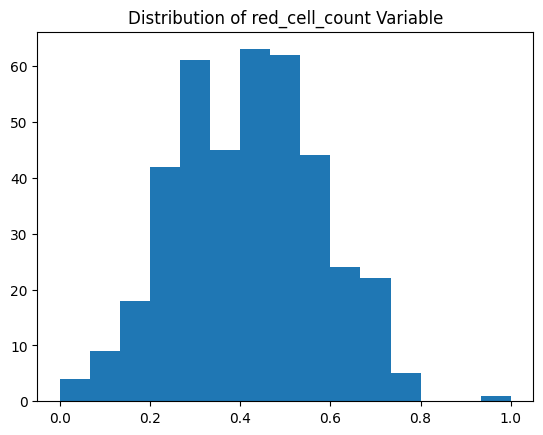

In [12]:
for col in continuous_vars:
    plt.hist(df_final[col], bins=15)
    plt.title('Distribution of '+ col+ ' Variable')
    plt.show()

From this set of plots, we see that the variables: age, blood pressure, blood glucose (random), blood urea, hemoglobin,  packed cell volume, white cell count, and red cell count follow a somewhat normal distribution. 

However, the other variables show some evident subgroups. For example, the sugar variable shows a few distinct bins. This is because the values are not continuous. Instead, patients are sorted into 5 groups (numbered 1,2,3,4,5 prior to scaling) that rank their sugar levels. We see similar behaviour with the variable albumin and specific gravity

In [13]:
df['sugar'].unique()

array([ 0.,  3.,  4.,  1., nan,  2.,  5.])

In [14]:
df['albumin'].unique()

array([ 1.,  4.,  2.,  3.,  0., nan,  5.])

In [15]:
df['specific_gravity'].unique()


array([1.02 , 1.01 , 1.005, 1.015,   nan, 1.025])

### Question 8 - Data Splitting

In [16]:
# Assigning predictors and response variables
pred_vars = df_final.columns.tolist()[:-1]
resp_var = ['class']
x = df_final[pred_vars]
y = df_final[resp_var]

# Splitting into 70%/30% training/test split with stratified random sampling and seed=1
x_train, x_test, y_train, y_test = train_test_split(
    x, 
    y,
    test_size=0.3, 
    random_state=1, 
    stratify=y
    )

### Question 9 - Classifier Choices
**KNN Classification**
The first classifier chosen is K-Nearest Neighbours. This is because the KNN classifier is a good, simple way to understand the relationship between different variables. However, since the outliers have not been removed, it's possible KNN will not perform well. 

**Decision Trees**
Since there are many dimensions to this data (25!), a decision tree classifier is a good option to battle the curse of dimensionality.

### Question 10 - Performance Metrics
For both classifers, we can look at the accuracy measure to determine which performs better. For KNN classification, the accuracy can be optimized relative to the number of neighbours. For decision trees, we can optimize based on depth. 

#### KNN Implementation
Before using KNN, the categorical variables (with string labels) need to be converted to numerical values. And all nan values will have to be dropped.

In [17]:
obj_vars = df_final.select_dtypes(include=['object']).columns
for col in obj_vars:
    print(col)
    display(df_final[col].unique())

red_blood_cells


array([nan, 'normal', 'abnormal'], dtype=object)

pus_cells


array(['normal', 'abnormal', nan], dtype=object)

pus_cell_clumps


array(['notpresent', 'present', nan], dtype=object)

bacteria


array(['notpresent', 'present', nan], dtype=object)

hypertension


array(['yes', 'no', nan], dtype=object)

diabetes_mel


array(['yes', 'no', nan], dtype=object)

coronary_heart_disease


array(['no', 'yes', nan], dtype=object)

appetite


array(['good', 'poor', nan], dtype=object)

pedal_enema


array(['no', 'yes', nan], dtype=object)

anemia


array(['no', 'yes', nan], dtype=object)

class


array(['ckd', 'notckd'], dtype=object)

We can map these values to numbers and update the dataframe as follows.

In [18]:
var_map = {'normal': 0, 'abnormal': 1, 
           'notpresent': 0, 'present': 1, 
           'no': 0, 'yes': 1, 
           'good': 0, 'poor': 1, 
           'notckd': 0, 'ckd': 1, 
           }
df_knn = df_final.copy()
df_knn[obj_vars] = df_final[obj_vars].apply(lambda x: x.map(var_map))
df_knn.dropna(inplace=True)
df_knn[obj_vars]

,red_blood_cells,pus_cells,pus_cell_clumps,bacteria,hypertension,diabetes_mel,coronary_heart_disease,appetite,pedal_enema,anemia,class
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1
3,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1
8,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...
395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


After doing this, we can resplit the training/test data with this updated data and perform the KNN algorithm.

In [19]:
# Assigning predictors and response variables
pred_vars_knn = df_knn.columns.tolist()[:-1]
resp_vars_knn = ['class']
x_knn = df_knn[pred_vars]
y_knn = df_knn[resp_var]

# Splitting into 70%/30% training/test split with stratified random sampling and seed=1
x_train_knn, x_test_knn, y_train_knn, y_test_knn = train_test_split(
    x_knn, 
    y_knn,
    test_size=0.3, 
    random_state=1, 
    stratify=y_knn
    )

In [22]:
# Define the range of K values to explore
k_values = range(1, 15)

# Initialize lists to store accuracies for different K values
train_accuracies = []
test_accuracies = []

# Loop through each K value
for k in k_values:
    # Create KNN classifier with current K value
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    
    # Fit the classifier to the training data
    knn_classifier.fit(x_train_knn, y_train_knn)
    
    # Predict the training and test data labels
    train_predictions = knn_classifier.predict(x_train_knn)
    test_predictions = knn_classifier.predict(x_test_knn)
    
    # Calculate accuracy for training and test data
    train_accuracy = accuracy_score(y_train_knn, train_predictions)
    test_accuracy = accuracy_score(y_test_knn, test_predictions)
    
    # Append accuracies to the lists
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

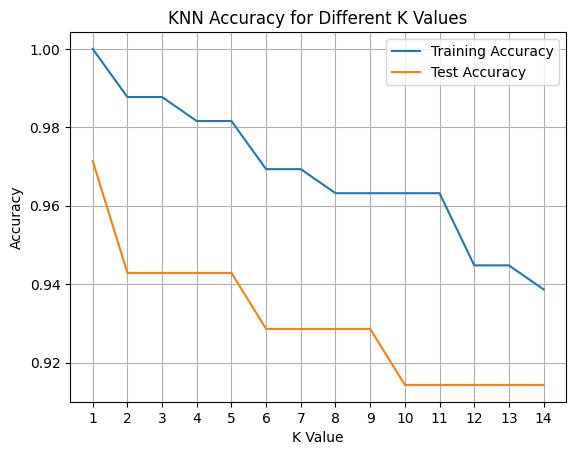

In [23]:
# Plot the accuracies for different K values
plt.plot(k_values, train_accuracies, label='Training Accuracy')
plt.plot(k_values, test_accuracies, label='Test Accuracy')
plt.title('KNN Accuracy for Different K Values')
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()

From these results, it sppears that k values of 1 leads to the best result. This k value has a training and test accuracy of 100% and 99% respectively. However, due to the size of the dataset, it is possible that this is a result of overfitting to this dataset. And for new data, it is likely better to use a value of a higher k value. To avoid overfitting, we could use a larger k value which has a high accuracy but it is more likely that new data will still be accurate as the model is not overfit.

Supposing we had more data, we might be able to find an optimal k value. For the purpose of this assignment, I will continue with k=5.

Accuracy score of k=5 is:  0.9428571428571428


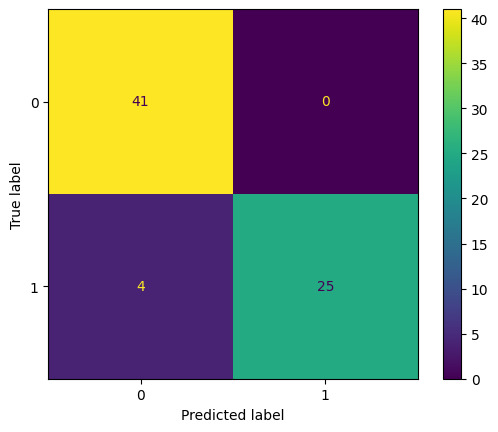

Classification Report :- 
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        41
           1       1.00      0.86      0.93        29

    accuracy                           0.94        70
   macro avg       0.96      0.93      0.94        70
weighted avg       0.95      0.94      0.94        70



In [26]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Fit the classifier to the training data
knn_classifier.fit(x_train_knn, y_train_knn)

# Predict the training and test data labels
test_predictions = knn_classifier.predict(x_test_knn)

print('Accuracy score of k=5 is: ', accuracy_score(y_test_knn, test_predictions))

cm = confusion_matrix(y_test_knn, test_predictions)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

print(f"Classification Report :- \n {classification_report(y_test_knn, test_predictions)}")

This shows that KNN classification with k=5 has a high accuracy and precision. That said, it is important to note that the number of observations is low. Since KNN classification cannot handle nan values, and it is difficult to accurately impute categorical data, the missing categorical data rows had to be dropped. So, instead of the original 400 rows, there were 233 rows.

As a result, even though the accuracy is high it is possible that the data was overfit.

#### Decision Trees Classification
To keep things consistent, we will continue to use the dataframe with categorical values encoded as numerical values. Note that decision trees technically do not need this, and can take in string values.

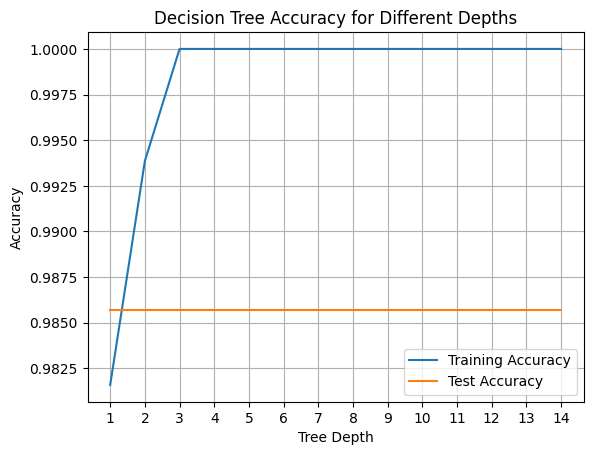

In [27]:
# Define the range of tree depths to explore
depths = range(1, 15)

# Initialize lists to store accuracies for different depths
train_accuracies = []
test_accuracies = []

# Loop through each depth
for depth in depths:
    # Create Decision Tree classifier with current depth
    dt_classifier = DecisionTreeClassifier(max_depth=depth, random_state=1)
    
    # Fit the classifier to the training data
    dt_classifier.fit(x_train_knn, y_train_knn)
    
    # Predict the training and test data labels
    train_predictions = dt_classifier.predict(x_train_knn)
    test_predictions = dt_classifier.predict(x_test_knn)
    
    # Calculate accuracy for training and test data
    train_accuracy = accuracy_score(y_train_knn, train_predictions)
    test_accuracy = accuracy_score(y_test_knn, test_predictions)
    
    # Append accuracies to the lists
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Plot the accuracies for different depths
plt.plot(depths, train_accuracies, label='Training Accuracy')
plt.plot(depths, test_accuracies, label='Test Accuracy')
plt.title('Decision Tree Accuracy for Different Depths')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.xticks(depths)
plt.legend()
plt.grid(True)
plt.show()

From these results, it appears that all depths of the tree lead to a high accuracy. However like with KNN data, it is possible that this is a result of overfitting to this dataset. To account for that, we can continue with a tree depth of 5. However the optimal depth would ideally be decided with more data. 

Using a depth of 5, we can look at the confusion matrix.

Accuracy score of depth=5 is:  0.9857142857142858


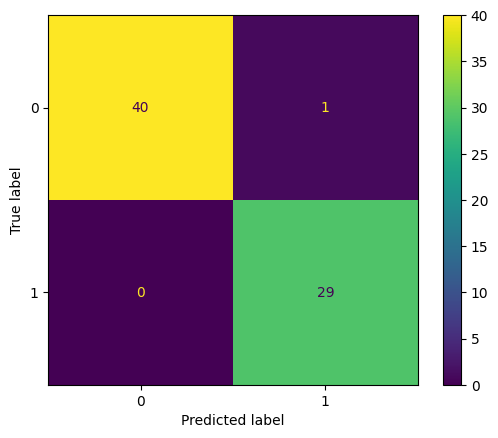

Classification Report :- 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        41
           1       0.97      1.00      0.98        29

    accuracy                           0.99        70
   macro avg       0.98      0.99      0.99        70
weighted avg       0.99      0.99      0.99        70



In [34]:
dt_classifier = DecisionTreeClassifier(max_depth=5, random_state=1)
# Fit the classifier to the training data
dt_classifier.fit(x_train_knn, y_train_knn)

# Predict the training and test data labels
test_predictions = dt_classifier.predict(x_test_knn)
print('Accuracy score of depth=5 is: ', accuracy_score(y_test_knn, test_predictions))

cm = confusion_matrix(y_test_knn, test_predictions)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

print(f"Classification Report :- \n {classification_report(y_test_knn, test_predictions)}")

This shows that a depth of 5 in a decision tree leads to high accuracy and precision. There is only 1 false positive in the whole dataset which is excellent. However, as mentioned, this model does suffer from a small sample size. 

### Question 11/12 - Feature Extraction/Classifier Comparison
From these results, it is clear that decision trees have a higher accuracy than KNN (99 vs 95 for test data). However, it would be valuable to try and improve the data quality (less nan values) so that the data could be fit more accurately. Given the high accuracy of both models and that the limiting factor is data quality, there is no way to improve the model further. 

### Question 13 - Interpretable Classifier Insight
We can look at the decision tree features to understand what leads to the largest impact on chronic kidney disease.

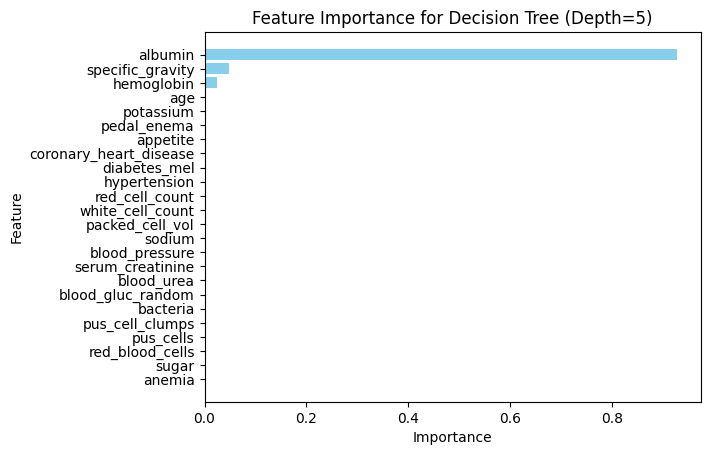

In [33]:
# Get feature importances from the trained Decision Tree classifier
feature_importances = dt_classifier.feature_importances_

feature_names = x_train_knn.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.title('Feature Importance for Decision Tree (Depth=5)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()

This plot shows that albumin is the most important factor by far. specific_gravity and hemoglobin are also important, and all other variables are essentially insignificant. This partially aligns with the data given in the provided article, [Sanmarchi et al., (2023)](https://link.springer.com/article/10.1007/s40620-023-01573-4) which finds albumin, creatinine, and hemoglobin to be the most important factors concerning CKD diagnosis.

### Question 15 - Team Contributions
This project was completed individually.

### Question 16 - Public Git Repo
https://github.com/melina-a/stats3d

(note that I will keep the repo private until Apr 19 so as to avoid plagirism)